In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

In [2]:
torch.manual_seed(42)

In [3]:
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [4]:
print(torch.__version__)
print(torch.version.cuda)

2.10.0+cpu
None


In [5]:
# Transforms
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

Converting to tensor ( / 255.0 ) and centering around mean = 0.5, std dev = 0.5

In [6]:
full_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_data = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

generator = torch.Generator().manual_seed(42)

train_data, val_data = random_split(
    full_dataset,
    [50000, 10000],
    generator=generator
)

In [7]:
print(f"Number of training images: {len(train_data)}")
print(f"Number of test images: {len(test_data)}")
print(f"Number of validation samples: {len(val_data)}")

Number of training images: 50000
Number of test images: 10000
Number of validation samples: 10000


In [8]:
raw_labels = train_data.dataset.targets[train_data.indices]

print(f"First 20 raw labels:\n{raw_labels[:20]}")

print(f"\nUnique labels in the dataset:\n{torch.unique(raw_labels)}")

First 20 raw labels:
tensor([9, 2, 5, 0, 5, 1, 3, 5, 0, 1, 1, 4, 4, 0, 9, 2, 6, 2, 1, 7])

Unique labels in the dataset:
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [9]:
classes = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [10]:
# Hyperparameters
batch_size = 256


Dimensions of a single image: <built-in method size of Tensor object at 0x7c4acd98efd0>
Mode of image: <built-in method mode of Tensor object at 0x7c4acd98efd0>
Label of the first image: Ankle boot (Class Index: 9)


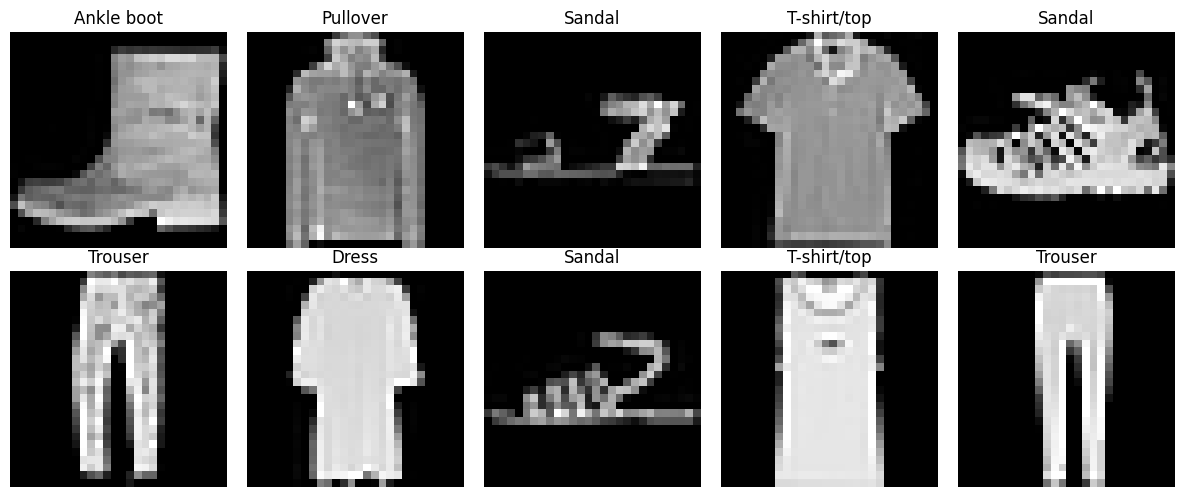

In [11]:
test_image, test_label = train_data[0]
print(f"\nDimensions of a single image: {test_image.size}")
print(f"Mode of image: {test_image.mode}")
print(f"Label of the first image: {classes[test_label]} (Class Index: {test_label})")


plt.figure(figsize=(12, 5))
for i in range(10):
    img, label = train_data[i]
    plt.subplot(2, 5, i+1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(classes[label])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [12]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [13]:
import torch.nn as nn

# Generalized MLP class

class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[128, 64], num_classes=10,
                 dropout_rate=0.0, use_batchnorm=False, activation='relu'):
        super().__init__()

        self.flatten = nn.Flatten() # Flattens (28*28) matrix into 1D 784 pixel matrix

        activations = {
            'relu': nn.ReLU(),
            'leaky_relu': nn.LeakyReLU(),
            'sigmoid': nn.Sigmoid(),
            'tanh': nn.Tanh()
        }

        act_fn = activations.get(activation.lower(), nn.ReLU()) # Default to ReLU

        layers = []
        in_features = input_size

        for h in hidden_sizes:
            layers.append(nn.Linear(in_features, h))

            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h))

            layers.append(act_fn)

            if dropout_rate > 0.0:
                layers.append(nn.Dropout(dropout_rate))

            in_features = h

        layers.append(nn.Linear(in_features, num_classes))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(self.flatten(x))

Example: MLP(hidden_sizes=[128,64], dropout_rate=0.5, use_batchnorm=True)

Model flow:
Flatten
Linear(784→128)
BatchNorm
ReLU
Dropout
Linear(128→64)
BatchNorm
ReLU
Dropout
Linear(64→10)

In [14]:
# Utility functions for loss function and optimizers

def get_loss():
    return nn.CrossEntropyLoss()

def get_optimizer(model, name="adam", lr=0.001, weight_decay=1e-4):
    name = name.lower()

    if name == "adam":
        return torch.optim.Adam(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay
        )

    elif name == "sgd":
        return torch.optim.SGD(
            model.parameters(),
            lr=lr,
            momentum=0.9, # Using standard beta = 0.9
            weight_decay=weight_decay
        )

    else:
        raise ValueError("Optimizer must be 'adam' or 'sgd'")

def get_scheduler(optimizer, step_size=5, gamma=0.5):
    return torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=step_size,
        gamma=gamma
    )

In [15]:
# Stops training when x validation metric stops improving after a set number of epochs (patience)
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, save_path="best_model.pt"):
        self.patience = patience
        self.min_delta = min_delta
        self.save_path = save_path
        self.best_loss = float("inf")
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.save_path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [16]:
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler=None, early_stopper=None, epochs=20, device="cpu"):
    model.to(device)

    history = {
        "train_loss": [], # Record loss and accuracy values to plot
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(epochs): # no. of dataset samples / batch size gradient updates
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader: # Loops through every batch
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad() # Don't accumulate gradients
            outputs = model(images) # Forward pass, output is raw logits

            loss = criterion(outputs, labels) # Applies softmax and cross-entropy loss
            loss.backward() # Backprop (dL/dW)
            optimizer.step() # Gradient update according to optimizer chosen

            running_loss += loss.item() * images.size(0) # Dataset loss

            _, predicted = torch.max(outputs, 1) # Choose class with highest probability score
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        model.eval() # Dropout is off, batchnorm uses train stats
        val_loss_total = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss_total += loss.item() * images.size(0)

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss = val_loss_total / total
        val_acc = correct / total

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        if scheduler:
            scheduler.step()

        if early_stopper:
            early_stopper(val_loss, model)
            if early_stopper.early_stop:
                print(f"Early stopping at epoch {epoch+1}")
                break

        print(f"""
Epoch {epoch+1}/{epochs}
Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}
Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}
""")

    return history

For each epoch:

    TRAIN MODE
        forward
        loss
        backward
        update weights


    EVAL MODE
        forward only
        compute validation metrics


    adjust learning rate
    check early stopping
    save metrics

In [17]:
def plot_history(history, title="Training Curves"):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")

    plt.suptitle(title)
    plt.show()

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, loader, device="cpu"):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    accuracy = (all_preds == all_labels).mean()

    print(f"\nTest Accuracy: {accuracy:.4f}")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, cm, all_preds, all_labels

In [19]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8,6))
    plt.imshow(cm)
    plt.title("Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

In [20]:
def show_misclassified(model, loader, class_names, device="cpu", max_images=15):
    model.eval()
    shown = 0

    plt.figure(figsize=(12,8))

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(len(images)):
                if preds[i] != labels[i]:
                    plt.subplot(3,5,shown+1)
                    plt.imshow(images[i].cpu().squeeze(), cmap="gray")
                    plt.title(f"P:{class_names[preds[i].item()]}\nT:{class_names[labels[i].item()]}")
                    plt.axis("off")

                    shown += 1
                    if shown >= max_images:
                        plt.tight_layout()
                        plt.show()
                        return

In [21]:
import pandas as pd

def build_results_table(results_dict):
    """
    results_dict format:
    {
        "Model Name": {
            "accuracy": float,
            "precision": float,
            "recall": float,
            "f1": float,
            "notes": str
        }
    }
    """

    rows = []
    for model_name, metrics in results_dict.items():
        row = {
            "Model": model_name,
            "Accuracy": metrics["accuracy"],
            "Precision": metrics["precision"],
            "Recall": metrics["recall"],
            "F1 Score": metrics["f1"],
            "Notes": metrics.get("notes", "")
        }
        rows.append(row)

    df = pd.DataFrame(rows)
    df = df.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

    return df

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

def get_metrics(labels, preds):
    return {
        "accuracy": (preds == labels).mean(),
        "precision": precision_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro"),
        "f1": f1_score(labels, preds, average="macro")
    }

In [23]:
results = {}
histories = {}

In [24]:
def run_experiment(
    name,
    hidden_sizes,
    optimizer_name="adam",
    lr=0.001,
    dropout=0.0,
    batchnorm=False,
    epochs=20
):
    print(f"\n========== Running {name} ==========")

    model = MLP(
    hidden_sizes=hidden_sizes,
    dropout_rate=dropout,
    use_batchnorm=batchnorm
)

    criterion = get_loss()
    optimizer = get_optimizer(model, optimizer_name, lr)
    scheduler = get_scheduler(optimizer)
    early_stopper = EarlyStopping(patience=5, save_path=f"{name}.pt")

    history = train_model(
        model,
        train_loader,
        val_loader,
        optimizer,
        criterion,
        scheduler,
        early_stopper,
        epochs,
        device
    )

    model.load_state_dict(torch.load(f"{name}.pt"))

    acc, cm, preds, labels = evaluate_model(model, test_loader, device)

    metrics = get_metrics(labels, preds)

    results[name] = metrics
    histories[name] = history

    plot_history(history, name)
    plot_confusion_matrix(cm, classes)

    show_misclassified(model, test_loader, classes, device)

    print("Finished:", name)


========== Running Baseline_Adam ==========

Epoch 1/20
Train Loss: 0.5971 | Train Acc: 0.7930
Val   Loss: 0.4636 | Val   Acc: 0.8370


Epoch 2/20
Train Loss: 0.4241 | Train Acc: 0.8490
Val   Loss: 0.4205 | Val   Acc: 0.8517


Epoch 3/20
Train Loss: 0.3832 | Train Acc: 0.8630
Val   Loss: 0.3879 | Val   Acc: 0.8608


Epoch 4/20
Train Loss: 0.3589 | Train Acc: 0.8706
Val   Loss: 0.3783 | Val   Acc: 0.8648


Epoch 5/20
Train Loss: 0.3379 | Train Acc: 0.8767
Val   Loss: 0.3955 | Val   Acc: 0.8600


Epoch 6/20
Train Loss: 0.3122 | Train Acc: 0.8869
Val   Loss: 0.3436 | Val   Acc: 0.8770


Epoch 7/20
Train Loss: 0.3037 | Train Acc: 0.8897
Val   Loss: 0.3416 | Val   Acc: 0.8792


Epoch 8/20
Train Loss: 0.2947 | Train Acc: 0.8934
Val   Loss: 0.3497 | Val   Acc: 0.8754


Epoch 9/20
Train Loss: 0.2879 | Train Acc: 0.8969
Val   Loss: 0.3346 | Val   Acc: 0.8804


Epoch 10/20
Train Loss: 0.2818 | Train Acc: 0.8991
Val   Loss: 0.3371 | Val   Acc: 0.8787


Epoch 11/20
Train Loss: 0.2679 | Train Acc:

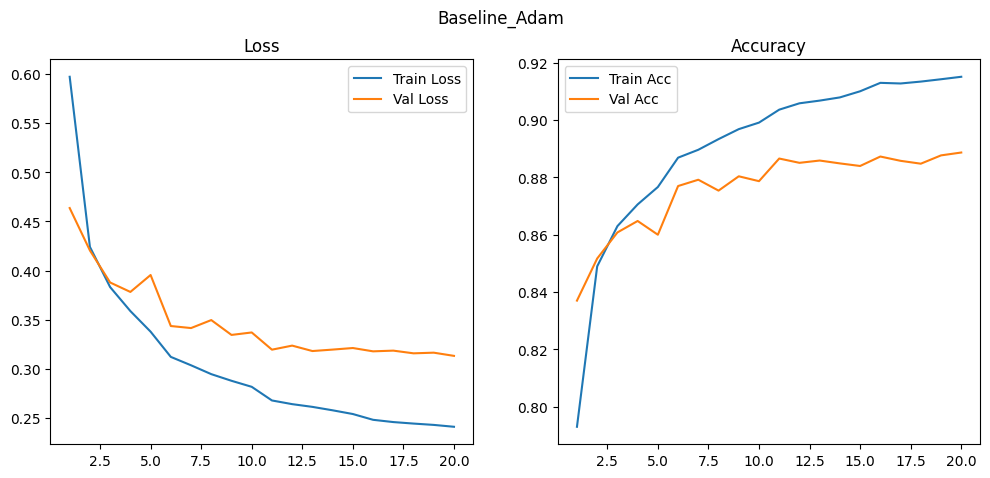

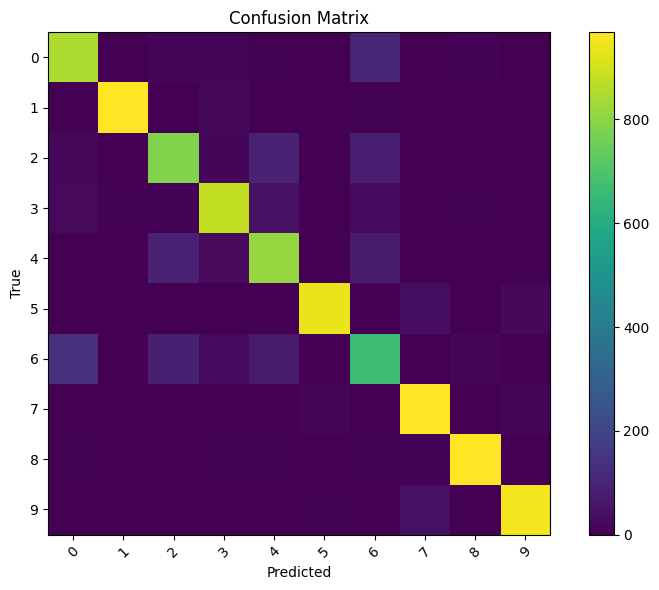

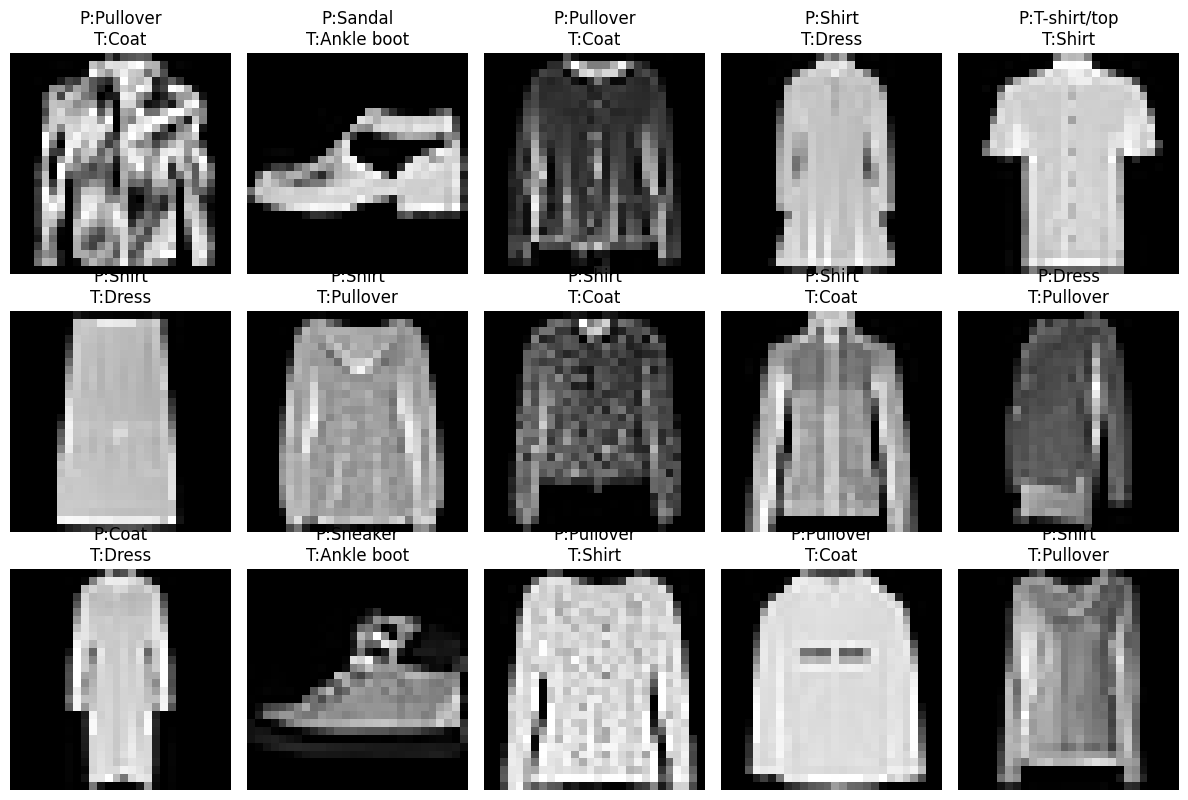

Finished: Baseline_Adam


In [25]:
run_experiment(
    "Baseline_Adam",
    hidden_sizes=[128],
    optimizer_name="adam",
    lr=0.001
)


========== Running Baseline_SGD ==========

Epoch 1/20
Train Loss: 0.7345 | Train Acc: 0.7481
Val   Loss: 0.5228 | Val   Acc: 0.8191


Epoch 2/20
Train Loss: 0.4690 | Train Acc: 0.8336
Val   Loss: 0.4769 | Val   Acc: 0.8304


Epoch 3/20
Train Loss: 0.4279 | Train Acc: 0.8478
Val   Loss: 0.4268 | Val   Acc: 0.8475


Epoch 4/20
Train Loss: 0.4030 | Train Acc: 0.8562
Val   Loss: 0.4138 | Val   Acc: 0.8511


Epoch 5/20
Train Loss: 0.3859 | Train Acc: 0.8616
Val   Loss: 0.3937 | Val   Acc: 0.8605


Epoch 6/20
Train Loss: 0.3630 | Train Acc: 0.8706
Val   Loss: 0.3833 | Val   Acc: 0.8633


Epoch 7/20
Train Loss: 0.3550 | Train Acc: 0.8728
Val   Loss: 0.3794 | Val   Acc: 0.8655


Epoch 8/20
Train Loss: 0.3483 | Train Acc: 0.8758
Val   Loss: 0.3764 | Val   Acc: 0.8658


Epoch 9/20
Train Loss: 0.3424 | Train Acc: 0.8779
Val   Loss: 0.3676 | Val   Acc: 0.8689


Epoch 10/20
Train Loss: 0.3377 | Train Acc: 0.8790
Val   Loss: 0.3668 | Val   Acc: 0.8697


Epoch 11/20
Train Loss: 0.3287 | Train Acc: 

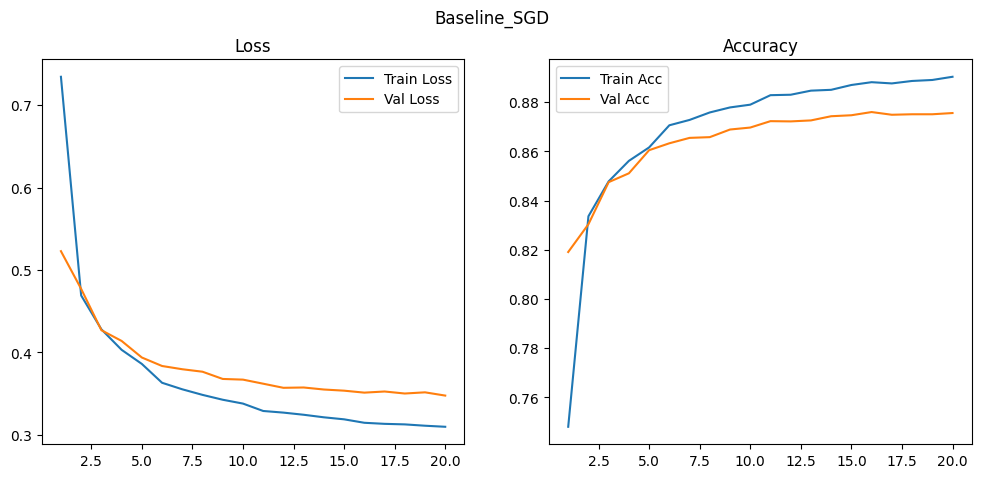

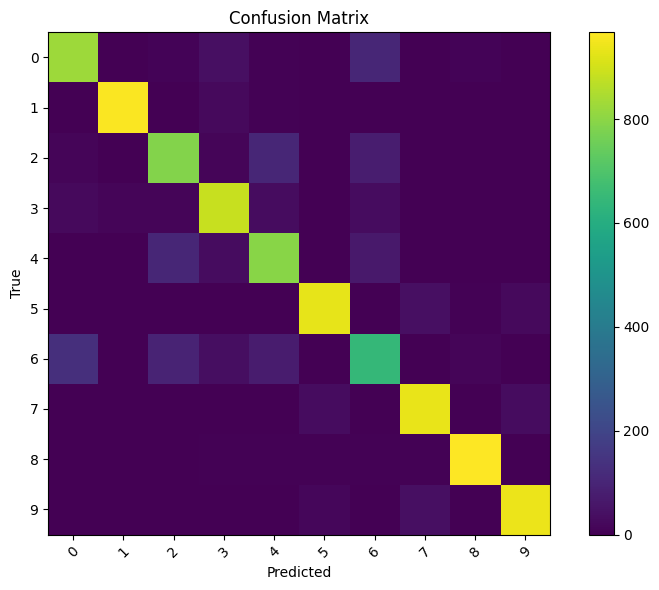

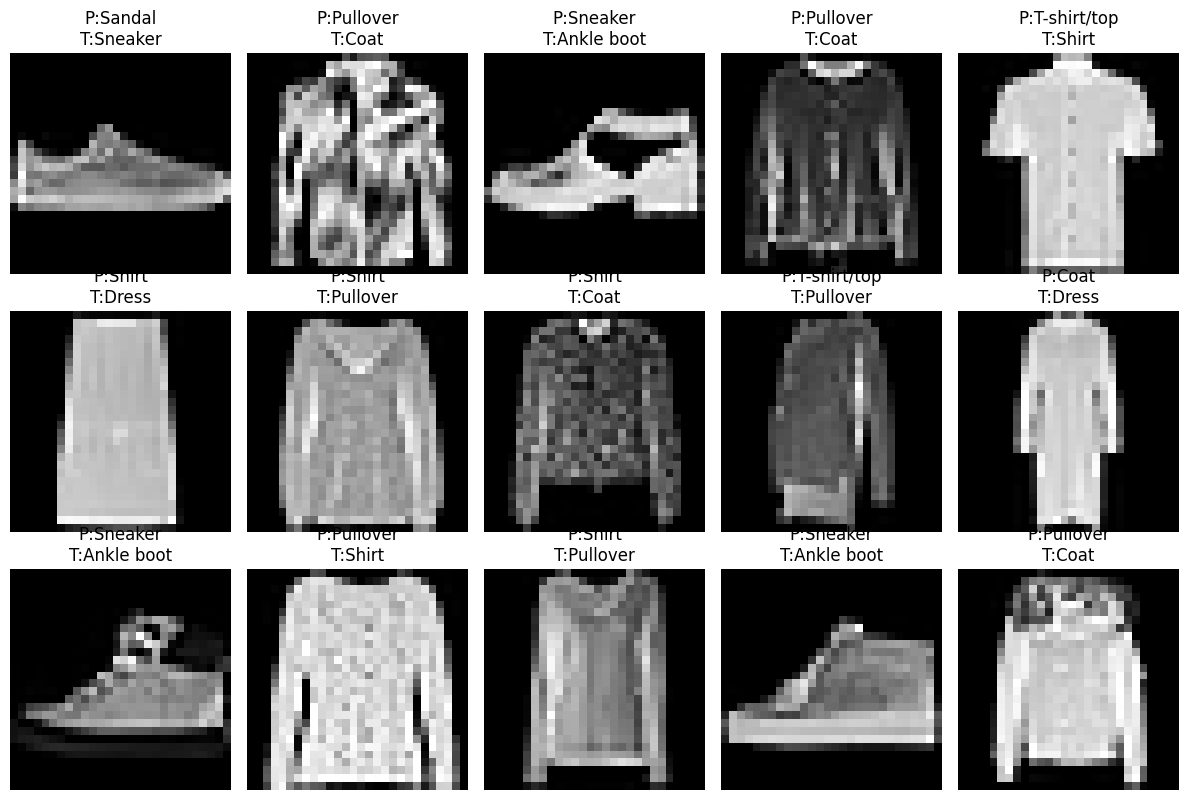

Finished: Baseline_SGD


In [26]:
run_experiment(
    "Baseline_SGD",
    hidden_sizes=[128],
    optimizer_name="sgd",
    lr=0.01
)

Adam accuracy: 0.8879
SGD: 0.8847

Adam convered slightly faster and better, but small difference (dataset is probably pretty simple)


========== Running Small_Model ==========

Epoch 1/20
Train Loss: 0.7139 | Train Acc: 0.7588
Val   Loss: 0.5099 | Val   Acc: 0.8256


Epoch 2/20
Train Loss: 0.4610 | Train Acc: 0.8372
Val   Loss: 0.4540 | Val   Acc: 0.8429


Epoch 3/20
Train Loss: 0.4246 | Train Acc: 0.8498
Val   Loss: 0.4412 | Val   Acc: 0.8487


Epoch 4/20
Train Loss: 0.4006 | Train Acc: 0.8581
Val   Loss: 0.4139 | Val   Acc: 0.8558


Epoch 5/20
Train Loss: 0.3847 | Train Acc: 0.8628
Val   Loss: 0.4087 | Val   Acc: 0.8568


Epoch 6/20
Train Loss: 0.3674 | Train Acc: 0.8691
Val   Loss: 0.3933 | Val   Acc: 0.8635


Epoch 7/20
Train Loss: 0.3609 | Train Acc: 0.8725
Val   Loss: 0.3901 | Val   Acc: 0.8642


Epoch 8/20
Train Loss: 0.3546 | Train Acc: 0.8739
Val   Loss: 0.3896 | Val   Acc: 0.8636


Epoch 9/20
Train Loss: 0.3512 | Train Acc: 0.8759
Val   Loss: 0.3830 | Val   Acc: 0.8661


Epoch 10/20
Train Loss: 0.3451 | Train Acc: 0.8779
Val   Loss: 0.3783 | Val   Acc: 0.8675


Epoch 11/20
Train Loss: 0.3372 | Train Acc: 0

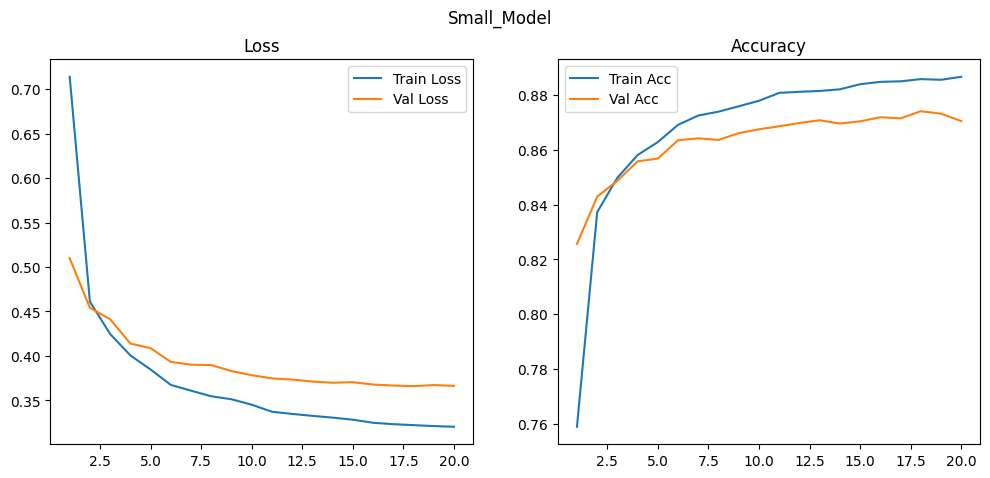

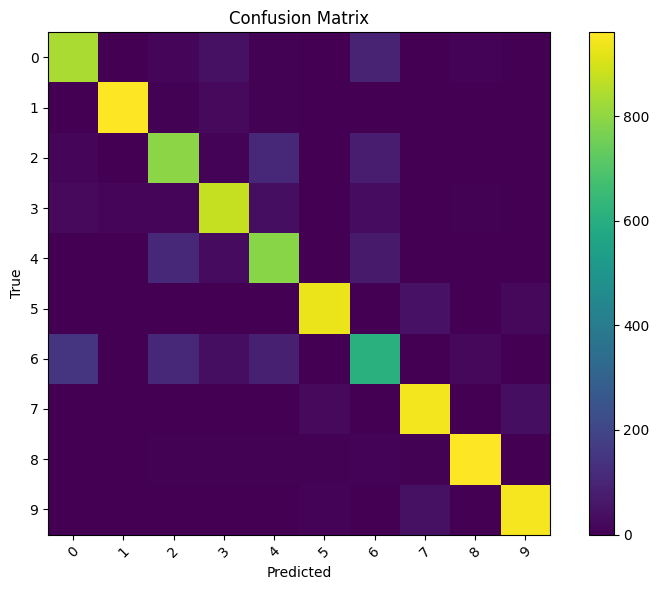

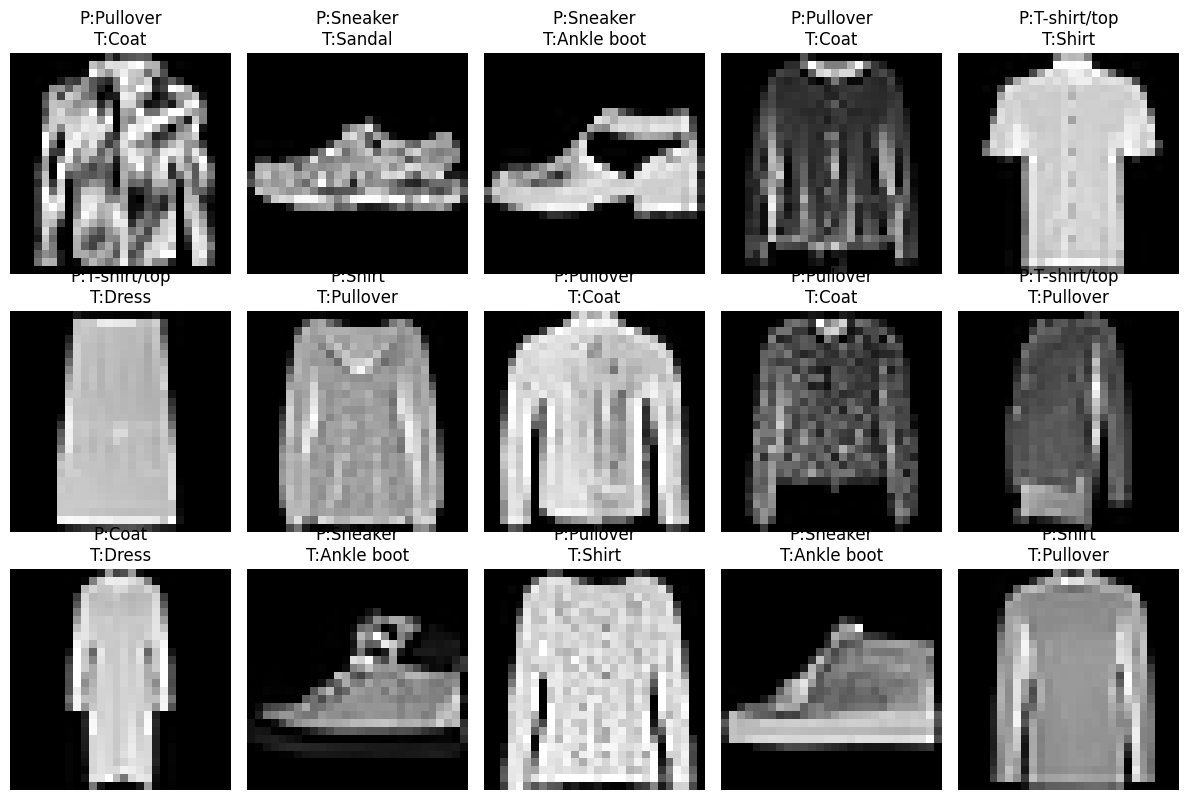

Finished: Small_Model


In [27]:
run_experiment(
    "Small_Model",
    hidden_sizes=[32]
)

Clearly underfitting, lower test and train accuracies compared to other models, plateaus earlier


========== Running Deep_Model ==========

Epoch 1/20
Train Loss: 0.5999 | Train Acc: 0.7819
Val   Loss: 0.4449 | Val   Acc: 0.8393


Epoch 2/20
Train Loss: 0.3937 | Train Acc: 0.8571
Val   Loss: 0.3716 | Val   Acc: 0.8680


Epoch 3/20
Train Loss: 0.3546 | Train Acc: 0.8682
Val   Loss: 0.3427 | Val   Acc: 0.8765


Epoch 4/20
Train Loss: 0.3231 | Train Acc: 0.8804
Val   Loss: 0.3631 | Val   Acc: 0.8683


Epoch 5/20
Train Loss: 0.3075 | Train Acc: 0.8852
Val   Loss: 0.3729 | Val   Acc: 0.8617


Epoch 6/20
Train Loss: 0.2650 | Train Acc: 0.9022
Val   Loss: 0.3216 | Val   Acc: 0.8835


Epoch 7/20
Train Loss: 0.2522 | Train Acc: 0.9057
Val   Loss: 0.3017 | Val   Acc: 0.8926


Epoch 8/20
Train Loss: 0.2379 | Train Acc: 0.9114
Val   Loss: 0.3034 | Val   Acc: 0.8929


Epoch 9/20
Train Loss: 0.2320 | Train Acc: 0.9130
Val   Loss: 0.3117 | Val   Acc: 0.8893


Epoch 10/20
Train Loss: 0.2229 | Train Acc: 0.9171
Val   Loss: 0.3121 | Val   Acc: 0.8859


Epoch 11/20
Train Loss: 0.1967 | Train Acc: 0.

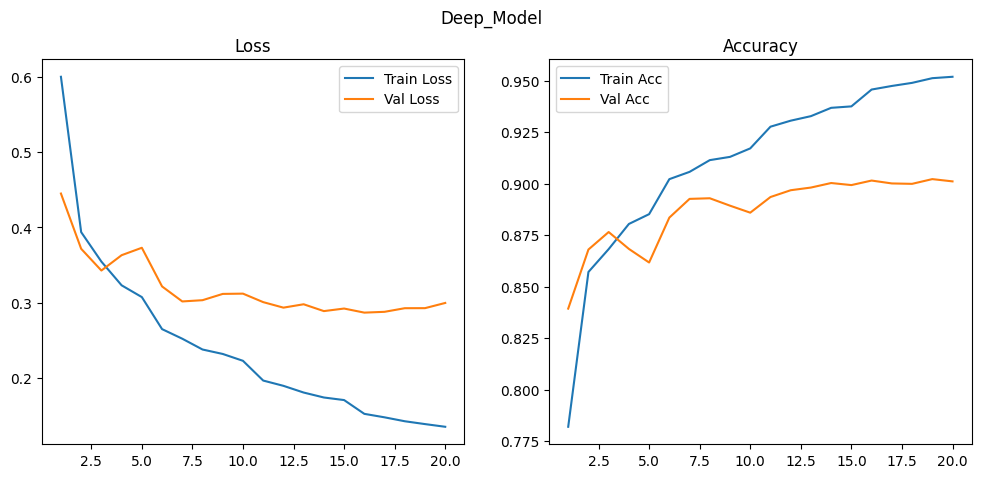

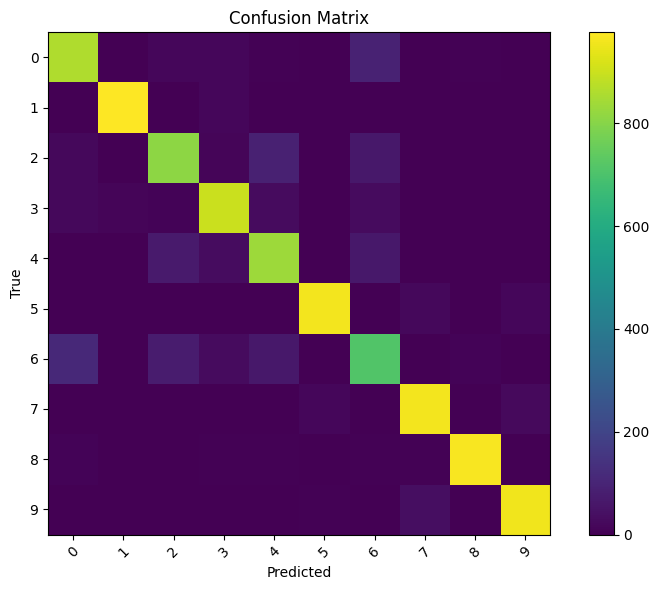

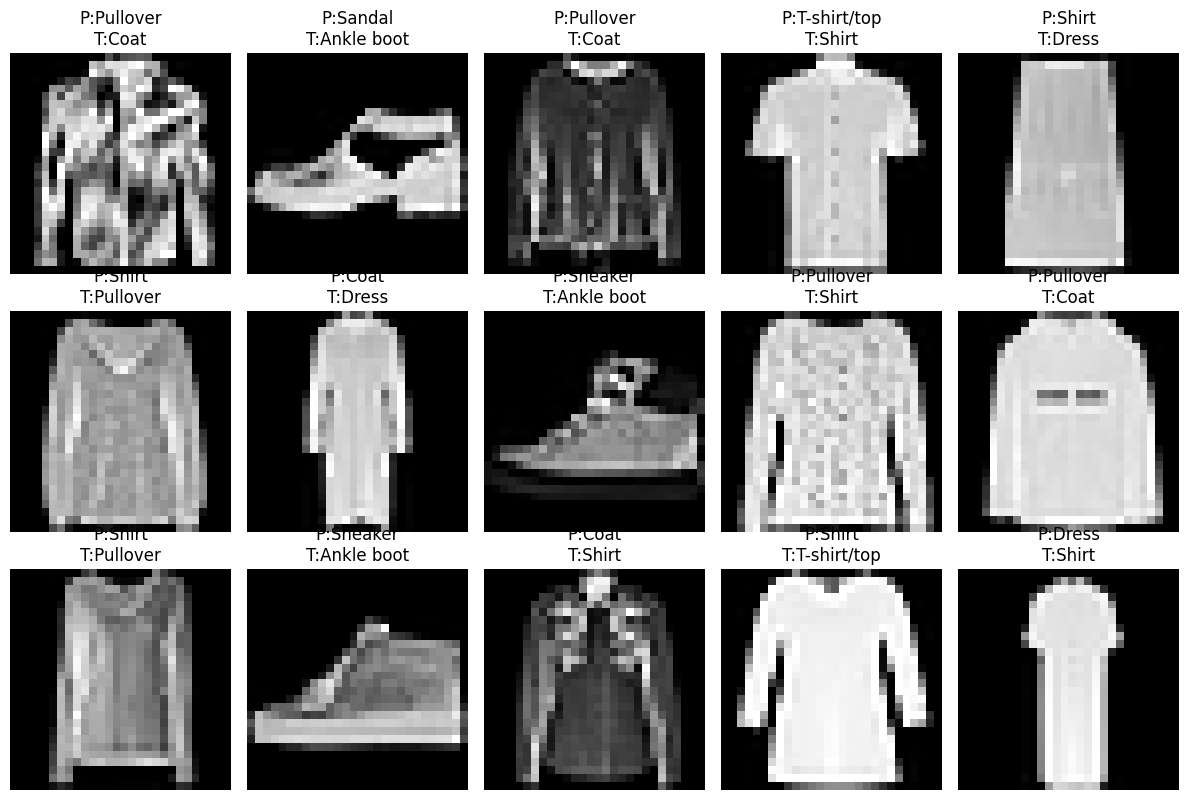

Finished: Deep_Model


In [28]:
run_experiment(
    "Deep_Model",
    hidden_sizes=[512,256,128]
)


========== Running Very_Deep ==========

Epoch 1/20
Train Loss: 0.6098 | Train Acc: 0.7739
Val   Loss: 0.4285 | Val   Acc: 0.8441


Epoch 2/20
Train Loss: 0.4011 | Train Acc: 0.8541
Val   Loss: 0.3698 | Val   Acc: 0.8615


Epoch 3/20
Train Loss: 0.3563 | Train Acc: 0.8695
Val   Loss: 0.3537 | Val   Acc: 0.8695


Epoch 4/20
Train Loss: 0.3287 | Train Acc: 0.8787
Val   Loss: 0.3477 | Val   Acc: 0.8712


Epoch 5/20
Train Loss: 0.3060 | Train Acc: 0.8870
Val   Loss: 0.3467 | Val   Acc: 0.8703


Epoch 6/20
Train Loss: 0.2617 | Train Acc: 0.9027
Val   Loss: 0.3105 | Val   Acc: 0.8873


Epoch 7/20
Train Loss: 0.2488 | Train Acc: 0.9068
Val   Loss: 0.3014 | Val   Acc: 0.8891


Epoch 8/20
Train Loss: 0.2376 | Train Acc: 0.9114
Val   Loss: 0.2984 | Val   Acc: 0.8904


Epoch 9/20
Train Loss: 0.2289 | Train Acc: 0.9135
Val   Loss: 0.3160 | Val   Acc: 0.8858


Epoch 10/20
Train Loss: 0.2254 | Train Acc: 0.9165
Val   Loss: 0.3018 | Val   Acc: 0.8932


Epoch 11/20
Train Loss: 0.1895 | Train Acc: 0.9

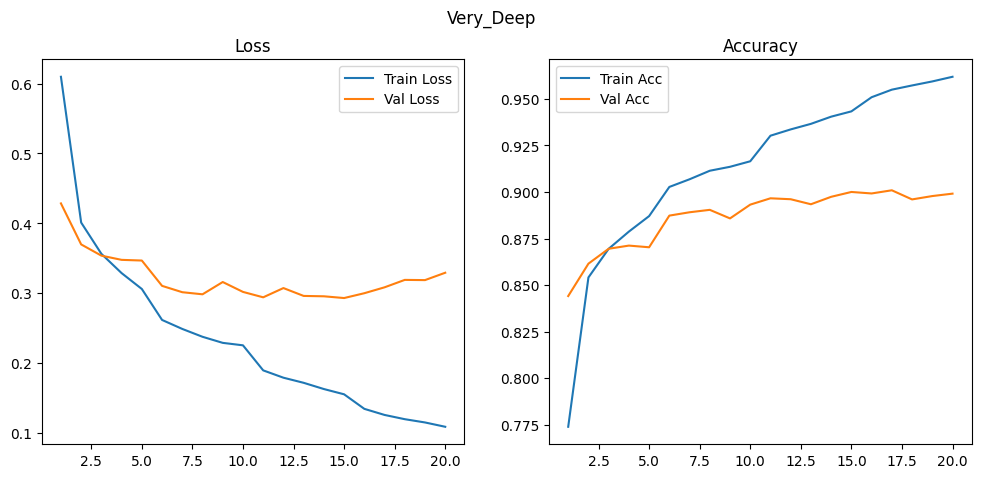

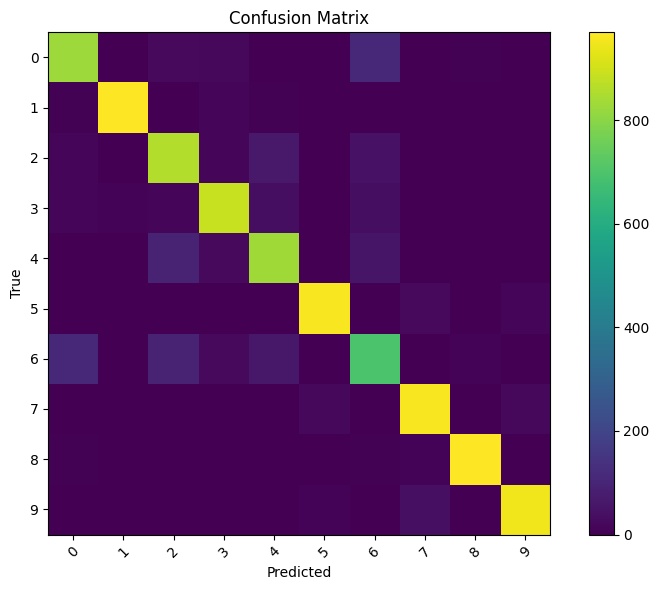

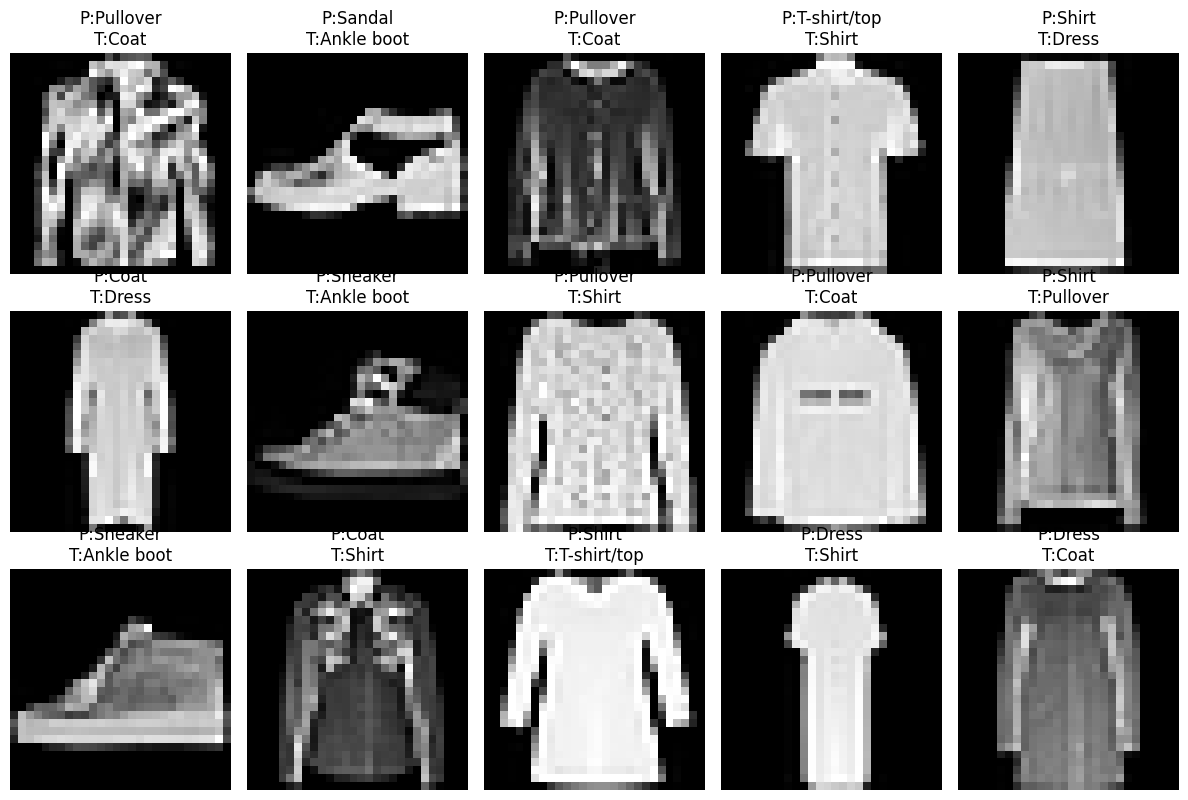

Finished: Very_Deep


In [29]:
run_experiment(
    "Very_Deep",
    hidden_sizes=[1024,512,256,128]
)

Compared to the previous models, accuracy went up; more layers means more non-linear activations and better learning capacity
The "very_deep" model caused accuracy to go down, overfitting, optimizing difficulty


========== Running Regularized ==========

Epoch 1/20
Train Loss: 0.7444 | Train Acc: 0.7583
Val   Loss: 0.4311 | Val   Acc: 0.8491


Epoch 2/20
Train Loss: 0.4872 | Train Acc: 0.8328
Val   Loss: 0.3959 | Val   Acc: 0.8544


Epoch 3/20
Train Loss: 0.4359 | Train Acc: 0.8473
Val   Loss: 0.3634 | Val   Acc: 0.8680


Epoch 4/20
Train Loss: 0.4124 | Train Acc: 0.8555
Val   Loss: 0.3572 | Val   Acc: 0.8697


Epoch 5/20
Train Loss: 0.3966 | Train Acc: 0.8603
Val   Loss: 0.3505 | Val   Acc: 0.8681


Epoch 6/20
Train Loss: 0.3614 | Train Acc: 0.8730
Val   Loss: 0.3195 | Val   Acc: 0.8828


Epoch 7/20
Train Loss: 0.3478 | Train Acc: 0.8779
Val   Loss: 0.3244 | Val   Acc: 0.8817


Epoch 8/20
Train Loss: 0.3415 | Train Acc: 0.8795
Val   Loss: 0.3128 | Val   Acc: 0.8853


Epoch 9/20
Train Loss: 0.3314 | Train Acc: 0.8830
Val   Loss: 0.3132 | Val   Acc: 0.8868


Epoch 10/20
Train Loss: 0.3242 | Train Acc: 0.8850
Val   Loss: 0.3137 | Val   Acc: 0.8857


Epoch 11/20
Train Loss: 0.3091 | Train Acc: 0

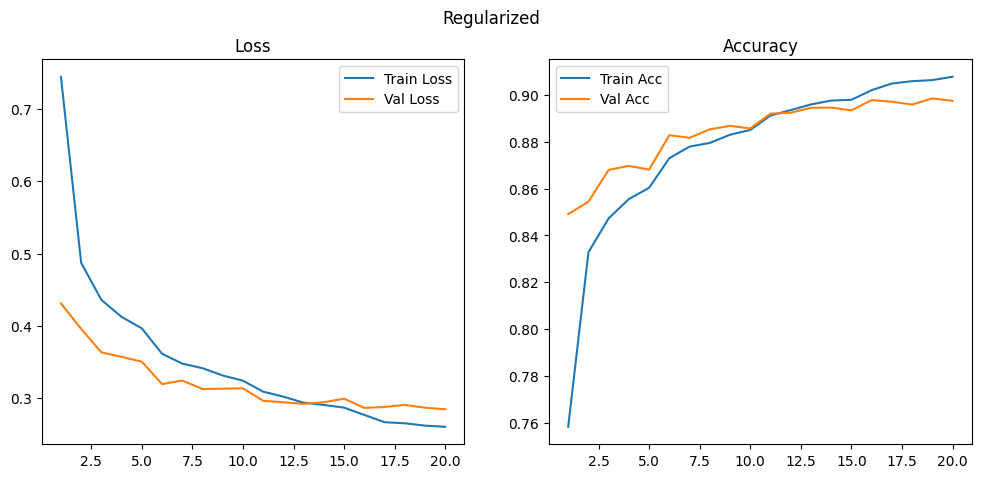

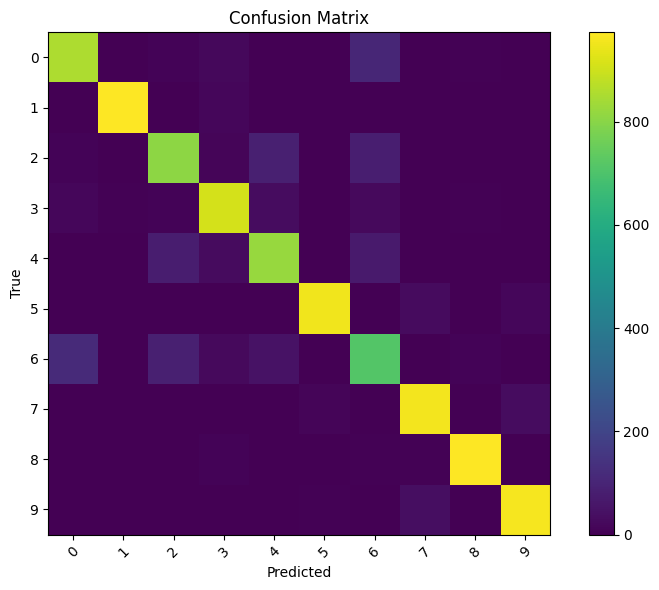

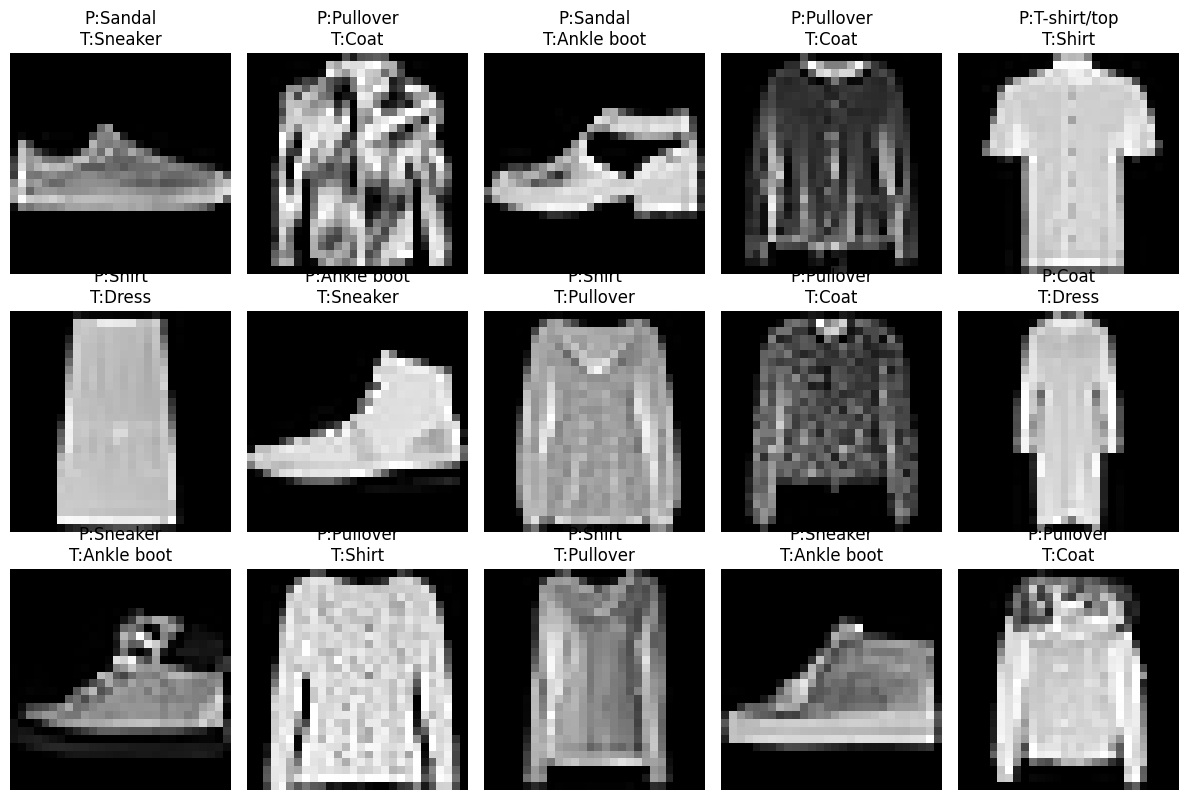

Finished: Regularized


In [30]:
run_experiment(
    "Regularized",
    hidden_sizes=[512,256,128],
    dropout=0.5,
    batchnorm=True
)

Best performer: High accuracy for both test and train, tiny gap in both (strong generalization)

In [31]:
run_experiment(
    "Tuned_Model",
    hidden_sizes=[512,256,128],
    lr=0.0005
)


========== Running Tuned_Model ==========

Epoch 1/20
Train Loss: 0.6657 | Train Acc: 0.7627
Val   Loss: 0.4757 | Val   Acc: 0.8279


Epoch 2/20
Train Loss: 0.4193 | Train Acc: 0.8466
Val   Loss: 0.3931 | Val   Acc: 0.8549



KeyboardInterrupt: 

1. Bias variance trade-off
Small model underfits (low test and train accuracies)
Deep model gives the best balance (high train and test accuracies, small gaps between both)
Super deep models overfit (sometimes lowers accuracies compared to the deep models, gap between test and train)

2. Capacity (performance curves)
Accuracy increases with complexity to a certain peak and then starts falling: Increases with depth and width til "deep" model and falls in the "very_deep" model

3. Regularization
Improved performance on previously overfitting models

The baseline model achieved strong performance, with Adam slightly outperforming SGD. Increasing model depth improved accuracy up to a point, after which additional layers reduced performance due to optimization difficulty and mild overfitting. The small model underfit the dataset, confirming low capacity. The regularized model achieved the highest accuracy (89.28%), demonstrating that appropriate regularization improves generalization by reducing overfitting while maintaining decent capacity.

Qualitative insights:

Misclassified samples show that most errors occur between visually similar categories such as shirts and coats. Most incorrect predictions corresponse to ambigious images, showing that maybe the model relies on textures and shape outlines more than finer details. This indicates that the network has learned meaningful visual representations but still struggles with subtle interclass differences.

## Representative under, over, and balanced fitting models

In [ ]:
small_hist = run_experiment(
    "Small_Model",
    hidden_sizes=[32]
)

deep_hist = run_experiment(
    "Very_Deep",
    hidden_sizes=[512,256,128,64]
)

reg_hist = run_experiment(
    "Regularized",
    hidden_sizes=[256,128],
    dropout=0.3,
    batchnorm=True
)

In [ ]:
def compare_histories(histories, labels):

    plt.figure(figsize=(14,5))

    plt.subplot(1,2,1)
    for hist,label in zip(histories, labels):
        plt.plot(hist["train_loss"], label=f"{label} Train")
        plt.plot(hist["val_loss"], linestyle="--", label=f"{label} Val")
    plt.title("Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1,2,2)
    for hist,label in zip(histories, labels):
        plt.plot(hist["train_acc"], label=f"{label} Train")
        plt.plot(hist["val_acc"], linestyle="--", label=f"{label} Val")
    plt.title("Accuracy Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
compare_histories(
    [small_hist, deep_hist, reg_hist],
    ["Underfit", "Overfit", "Best"]
)

## Additional task

In [ ]:
learning_rates = [0.01, 0.001, 0.0005]
hidden_configs = [[128], [256,128]]
dropouts = [0.0, 0.3]
# 3 * 2 * 2 = 12 models

def run_tuning():
    tuning_results = {}

    for lr in learning_rates:
        for hidden in hidden_configs:
            for drop in dropouts:

                name = f"LR{lr}_H{hidden}_D{drop}"

                print(f"\nRunning {name}")

                model = MLP(
                    hidden_sizes=hidden,
                    dropout_rate=drop
                )

                criterion = get_loss()
                optimizer = get_optimizer(model, "adam", lr)

                history = train_model(
                    model,
                    train_loader,
                    val_loader,
                    optimizer,
                    criterion,
                    epochs=15,
                    device=device
                )

                acc, _, preds, labels = evaluate_model(model, test_loader, device)

                tuning_results[name] = get_metrics(labels, preds)

    return tuning_results

In [ ]:
tuning_results = run_tuning()
build_results_table(tuning_results)

Best model: LR=0.0005, h=[256, 128], dropout=0.0

Learning rate analysis:
0.01 - unstable, overshooting
0.001 - decent
0.0005 - best performing, stable convergence

LR 0.01 - best = 0.8304
LR 0.001 - best = 0.8800
LR 0.0005 - best = 0.8844

Hidden layers analysis:
[256, 128] fits the best but the difference isn't too big, dataset is pretty simple

Dropout:
Models aren't overfitting much in the first place, regularization hurts overall accuracy but does increase test train accuracy gap in some models

LR dominates performance, dataset isn't complex enough to warrant strong regularization and high dropout

## Week 2 comparison

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

def loader_to_numpy(loader):
    X_list = []
    y_list = []

    for images, labels in loader:
        X_list.append(images.view(images.size(0), -1).numpy())
        y_list.append(labels.numpy())

    X = np.vstack(X_list)
    y = np.concatenate(y_list)

    return X, y


print("Converting dataset to numpy arrays")
X_train, y_train = loader_to_numpy(train_loader)
X_test, y_test = loader_to_numpy(test_loader)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


models = {
    "LogisticRegression": LogisticRegression(max_iter=200, n_jobs=-1),
    "LinearSVM": LinearSVC(max_iter=2000),
    "RandomForest": RandomForestClassifier(n_estimators=50, n_jobs=-1)
}

results_classical = {}

for name, model in models.items():
    print(f"\nTraining {name}")

    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)

    results_classical[name] = acc
    print(f"{name} Accuracy:", acc)


df_classical = pd.DataFrame(
    results_classical.items(),
    columns=["Model","Accuracy"]
).sort_values("Accuracy", ascending=False)

df_classical

Converting dataset to numpy arrays
(50000, 784) (50000,)
(10000, 784) (10000,)

Training LogisticRegression...
LogisticRegression Accuracy: 0.839

Training LinearSVM...
LinearSVM Accuracy: 0.8382

Training RandomForest...
RandomForest Accuracy: 0.8708


,Model,Accuracy
2,RandomForest,0.8708
0,LogisticRegression,0.8390
1,LinearSVM,0.8382


| Model | Type | Accuracy | Notes |
|------|------|------------------|------|
| Logistic Regression | Classical | 0.839 | Makes linear boundary decisions |
| Linear SVC | Classical | 0.8382 | Handles higher dimensional data better |
| Random Forest | Classical | 0.8708 | Captures nonlinear patterns well|
| MLP (Best Model) | Neural Network | **0.8928** | Learns nonlinear feature representations much better given more data |

Classical models achieved competitive performance but slightly underperformed compared to neural networks. Logistic regression and linear SVM perform decently because the dataset is based on pixel intensity that may be often linearly separable. Random forest performed the best out of traditional ML though random forest usually lacks spatial awareness. The MLP achieved the best accuracy by learning nonlinear representations, demonstrating the advantage of neural networks for image classification tasks.